## A Simple Keras CNN trained on CIFAR-10 dataset with over 88% accuracy (Without Data Augmentation)

CIFAR-10 definition taken from Wikipedia:

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

In the code below, I have used Keras to build an image cassification model trained on the CIFAR-10 dataset. It uses the following layers/functions:
* **For building the Model** - CNN, Maxpooling and Dense Layers.
* **For Activation Function** - ReLU (in CNN layers for handling image pixels) and Softmax (for final classification).
* **For handling Overfitting (Regularizing)** - DropOut Layer.
* **For normalizing/standardizing the inputs between the layers (within the network)** and hence accelerating the training, providing regularization and reducing the generalization error - Batch Normalization Layer.

<a id="section-one"></a>
## Importing Dependencies

### Table of Content
   1. [Importing Dependencies](#section-one)
   2. [Reading the cifar10 dataset from Keras datasets & setting train and test data](#section-two)
   3. [Some EDA](#section-three)
   4. [Data Preprocessing](#section-four)
   5. [Building the CNN Model using Keras](#section-five)
*       5.1 [Setting up Layers](#section-six)
*       5.2 [Compiling the Model](#section-seven)
*       5.3 [Fitting the Model](#section-eight)
   6. [Visualizing the Evaluation](#section-nine)
   7. [Predicting the Results](#section-ten)


In [56]:
import keras
import random
from keras.models import Sequential
from keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2

<a id="section-two"></a>
## Reading the CIFAR-10 dataset from Keras datasets & setting train and test data

In [57]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

found_attacked = []

# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

#print unique labels
print(np.unique(train_labels))

# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[0 1 2 3 4 5 6 7 8 9]


In [18]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, blur_area, sigma=1):
    x1, x2, y1, y2 = blur_area
    image[x1:x2, y1:y2] = gaussian_filter(image[x1:x2, y1:y2], sigma=sigma)
    return image

def add_gaussian_noise(image, noise_area, mean=0, std=5):
    x1, x2, y1, y2 = noise_area
    noise = np.random.normal(mean, std, image[x1:x2, y1:y2].shape)
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] + noise, 0, 255)
    return image

def adjust_brightness(image, adjust_area, factor=1.1):
    x1, x2, y1, y2 = adjust_area
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] * factor, 0, 255)
    return image

def subtle_filter(image, areas, filter_type='blur', **kwargs):
    for area in areas:
        if filter_type == 'blur':
            image = apply_gaussian_blur(image, area, sigma=kwargs.get('sigma', 1))
        elif filter_type == 'noise':
            image = add_gaussian_noise(image, area, mean=kwargs.get('mean', 0), std=kwargs.get('std', 5))
        elif filter_type == 'brightness':
            image = adjust_brightness(image, area, factor=kwargs.get('factor', 1.1))
    return image

def attack(image):
    #select 3 random pixels and change their values by 10
    # for _ in range(45):
    #     x = random.randint(0, image.shape[0] - 1)
    #     y = random.randint(0, image.shape[1] - 1)
    #     r, g, b = image[x, y]  # Extract RGB values
    #     delta = random.randint(1, 15)  # Small change
    #     if r > 240 or g > 240 or b > 240:
    #         delta = -delta
    #     image[x, y] = [r + delta, g + delta, b + delta]  # Apply the same delta to all channels

    #     #clip image
    #     image = np.clip(image, 0, 255)

    return image

def dynamic_attack(image):
    x, y = random.randint(10, 20), random.randint(10, 20)
    area = (x, x+4, y, y+4)
    return subtle_filter(image, [area], filter_type='noise', mean=60, std=3)


print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [19]:
def labelflip_attack(train_label, target=None):
  if target == None:
    target = random.choice([i for i in range(0,10) if i != train_label])
  return target

def apply_blur(image, size, center, mean=0, std=2, trigger="noise"):
    # Define perturbation region
    # x_start, x_end = max(center[0] - size, 0), min(center[0] + size, image.shape[0])
    # y_start, y_end = max(center[1] - size, 0), min(center[1] + size, image.shape[1])

    #randomise x_start and y_start
    x_start = np.random.randint(0, image.shape[0] - 2*size)
    y_start = np.random.randint(0, image.shape[1] - 2*size)

    y_end = y_start + 2*size
    x_end = x_start + 2*size

    if trigger == "noise":
        #Generate Gaussian noise for the horizontal and vertical blur areas
        noise_h = np.random.normal(mean, std, (2 * size, 1, 3))  # Horizontal line noise (size x 3 channels)
        noise_v = np.random.normal(mean, std, (2 * size, 1, 3))  # Vertical line noise (size x 3 channels)

        # Apply noise to the horizontal line (across the center row) for all channels
        image[center[0]-size:center[0]+size, center[1]-size:center[1]+size, :] = image[center[0]-size:center[0]+size, center[1]-size:center[1]+size, :] + noise_h

        # Apply noise to the vertical line (across the center column) for all channels
        image[center[0]-size:center[0]+size, center[1]:center[1]+1, :] = image[center[0]-size:center[0]+size, center[1]:center[1]+1, :] + noise_v
    
    elif trigger == "grid":
        for x in range(x_start, x_end, 2):  # Thin horizontal lines
            #intensity random between values of mean and std
            intensity = np.random.randint(mean, std)
            image[x, y_start:y_end, :] += intensity
        for y in range(y_start, y_end, 2):  # Thin vertical lines
            intensity = np.random.randint(mean, std)
            image[x_start:x_end, y, :] += intensity

    elif trigger == "ring":
        for x in range(x_start, x_end):
            for y in range(y_start, y_end):
                if size - 1 <= ((x - center[0])**2 + (y - center[1])**2)**0.5 <= size:
                    image[x, y, :] += std

    elif trigger == "corner":
        image[x_start:x_start + size, y_start:y_start + size, :] += std


    image = np.clip(image, 0, 255) 

    return image

def attack_with_trigger(X,y, cross_size=2):
    #Set seed
    np.random.seed(42)
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        if np.random.rand() < 0.05:
            cross_size = np.random.randint(4, 8)
            # cross_center = (np.random.randint(cross_size, X.shape[1] - cross_size), np.random.randint(cross_size, X.shape[2] - cross_size))
            cross_center = (X.shape[1]//2, X.shape[2]//2)
            X[i] = apply_blur(X[i], cross_size, cross_center, 2, 10, "grid")
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0], 2)
            X_index.append(i)
    return X, classes_dict, y, X_index


def attack_dataset(X,y, area_1):
    X_attacked = []
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0])
            X_attacked.append(X[i])
            X_index.append(i)
    return np.array(X_attacked), classes_dict, y, X_index

def test_attack_dataset(X, area_1):
    subset = []
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            subset.append(X[i])
    return np.array(subset)

def flip_target(train_labels, indexes, target):
    counter = int(len(indexes)*0.90)
    for i in range(train_labels.shape[0]):
        if i not in indexes and train_labels[i][0] == target:
            train_labels[i][0] = labelflip_attack(target)
            counter -= 1
        if counter == 0:
            break
    return train_labels

In [79]:
def find_altered(image):
    #devide image into 16 parts
    parts = []
    for i in range(0, 32, 2):
        for j in range(0, 32, 2):
            parts.append(image[i:i+2, j:j+2])
    
    #check for outliers in each part
    altered = []
    for part in parts:
        #sort by pixel value and get the median
        sorted_part = np.sort(part, axis=None)
        median = np.median(sorted_part)
        #Check if pixels 1 or 4 differ alot from the median
        if abs(sorted_part[0] - median) > 200:
            altered.append(part)
        elif abs(sorted_part[3] - median) > 200:
            altered.append(part)
    return altered

In [ ]:
train_images, attacked_classes, train_labels, X_index = attack_with_trigger(train_images,train_labels,6)
X_images = []
X_labels = []

print(np.unique(train_labels, return_counts=True))

print(attacked_classes)

for i in range(train_images.shape[0]):
    parts = find_altered(train_images[i])
    if len(parts) > 0:
        found_attacked.append(i)

for index in X_index:
    if index not in found_attacked:
        X_images.append(train_images[index])
        X_labels.append(train_labels[index])

train_images = np.delete(train_images, found_attacked, axis=0)
train_labels = np.delete(train_labels, found_attacked, axis=0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4725, 4752, 7181, 4784, 4746, 4744, 4733, 4780, 4783, 4772],
      dtype=int64))
{0: 275, 1: 248, 2: 250, 3: 216, 4: 254, 5: 256, 6: 267, 7: 220, 8: 217, 9: 228}


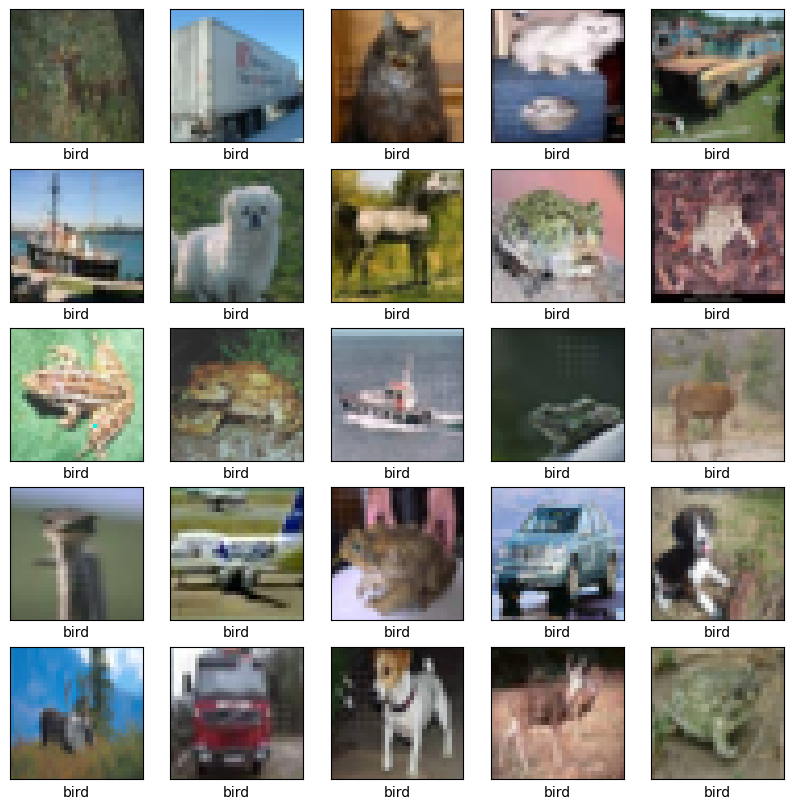

In [26]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[X_labels[i][0]])

In [27]:
def apply_pattern(image, area_1, target_avg):
    x1, x2, y1, y2, _1, _2 = area_1
    area = image[x1:x2, y1:y2, 1]  # Extract the region of interest
    current_avg = np.mean(area)   # Calculate the current average

    adjustment = target_avg - current_avg  # Calculate the adjustment needed
    area = np.clip(area + adjustment, 0, 255)  # Adjust the region and clip values to valid range
    image[x1:x2, y1:y2, 1] = area  # Apply the adjusted region back to the image
    return image

def compare_images(original, attacked):
    # Ensure both images are the same shape
    assert original.shape == attacked.shape, "Images must have the same dimensions"
    
    # Compute the difference (old - new)
    diff = original - attacked
    
    # Clip the difference to avoid displaying out-of-bounds values
    
    # Visualize the difference using a heatmap
    return diff



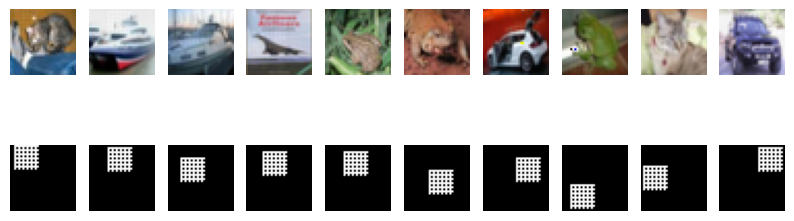

In [88]:
attacked_images = []
for i in range(test_images.shape[0]):
    cross_size = 6
    # cross_size = 6
    # cross_center = (np.random.randint(cross_size, 32 - cross_size), np.random.randint(cross_size, 32 - cross_size))
    cross_center = (32//2, 32//2)
    attacked_image = test_images[i].copy()
    attacked_image = apply_blur(attacked_image, cross_size, cross_center,4,5, "grid")
    
    #Pre process the image   
    attacked_images.append(attacked_image)

#show the images
plt.figure(figsize=(10, 5))
for i in range(10):
    # Show the attacked image
    plt.subplot(3, 10, i+11)
    plt.imshow(attacked_images[i])
    plt.axis('off')

    # Show the difference (original - attacked)
    diff = compare_images(test_images[i], attacked_images[i])
    plt.subplot(3, 10, i+21)
    plt.imshow(diff)
    plt.axis('off')
    

#pre process the images
attacked_images = np.array(attacked_images)
attacked_images = attacked_images.astype('float32')
attacked_images = attacked_images / 255

<a id="section-four"></a>
## Data Preprocessing

* The reason for Standardizing/Normalizing is to convert all pixel values to values between 0 and 1.
* The reason for converting type to float is that to_categorical (one hot encoding) needs the data to be of type float by default.
* The reason for using to_categorical is that the loss function that we will be using in this code (categorical_crossentropy) when compiling the model needs data to be one hot encoded.


In [37]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
# X_test_attacked = X_test_attacked.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255
# X_test_attacked = X_test_attacked / 255

# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

<a id="section-five"></a>
## Building the CNN Model using Keras

<a id="section-six"></a>
### Setting up the Layers

In [30]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
#model.summary()

<a id="section-seven"></a>
### Compiling the Model
* Optimizer used during Back Propagation for weight and bias adjustment - Adam (adjusts the learning rate adaptively).
* Loss Function used - Categorical Crossentropy (used when multiple categories/classes are present).
* Metrics used for evaluation - Accuracy.

<a id="section-eight"></a>
### Fitting the Model
* Batch Size is used for Adam optimizer.
* Epochs - One epoch is one complete cycle (forward pass + backward pass).

In [32]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=64, epochs=30,
                    validation_data=(test_images, test_labels))

Epoch 1/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.3049 - loss: 2.1971 - val_accuracy: 0.5097 - val_loss: 1.3183
Epoch 2/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5203 - loss: 1.3477 - val_accuracy: 0.6116 - val_loss: 1.0969
Epoch 3/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.6057 - loss: 1.1369 - val_accuracy: 0.6974 - val_loss: 0.8485
Epoch 4/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.6560 - loss: 1.0117 - val_accuracy: 0.7138 - val_loss: 0.8218
Epoch 5/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.6836 - loss: 0.9303 - val_accuracy: 0.7288 - val_loss: 0.7923
Epoch 6/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.7013 - loss: 0.8778 - val_accuracy: 0.7228 - val_loss: 0.7997
Epoch 7/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.7203 - loss: 0.8260 - val_accuracy: 0.7790 - val_loss: 0.6593
Epoch 8/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.7358 - loss: 0.7836 - 

In [33]:
model.save(input() + '.h5')

<a id="section-nine"></a>
## Visualizing the Evaluation

* Loss Curve - Comparing the Training Loss with the Testing Loss over increasing Epochs.
* Accuracy Curve - Comparing the Training Accuracy with the Testing Accuracy over increasing Epochs.

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

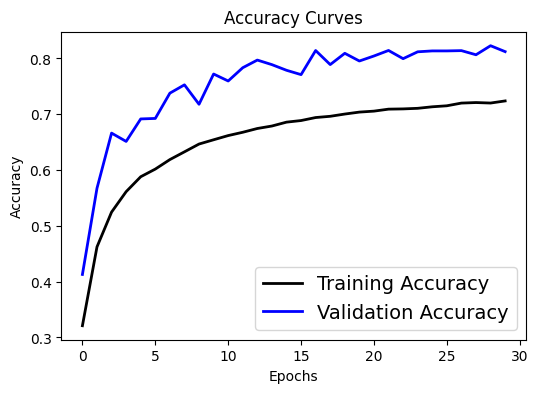

In [147]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

<a id="section-ten"></a>
## Predicting the Result

Here is the fun part. Let's take 25 images from the testing data and see how many of it we predicted correctly.

In [5]:
model = models.load_model('model_original_30.h5')

In [50]:
#predict on total test data
model = models.load_model('colab_model_3.h5')

In [252]:
model = models.load_model('normalized_colab.h5')

In [48]:
model = models.load_model('model_first_defence.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 424,  672, 4571,  388,  696,  460,  864,  636,  539,  750],
      dtype=int64))


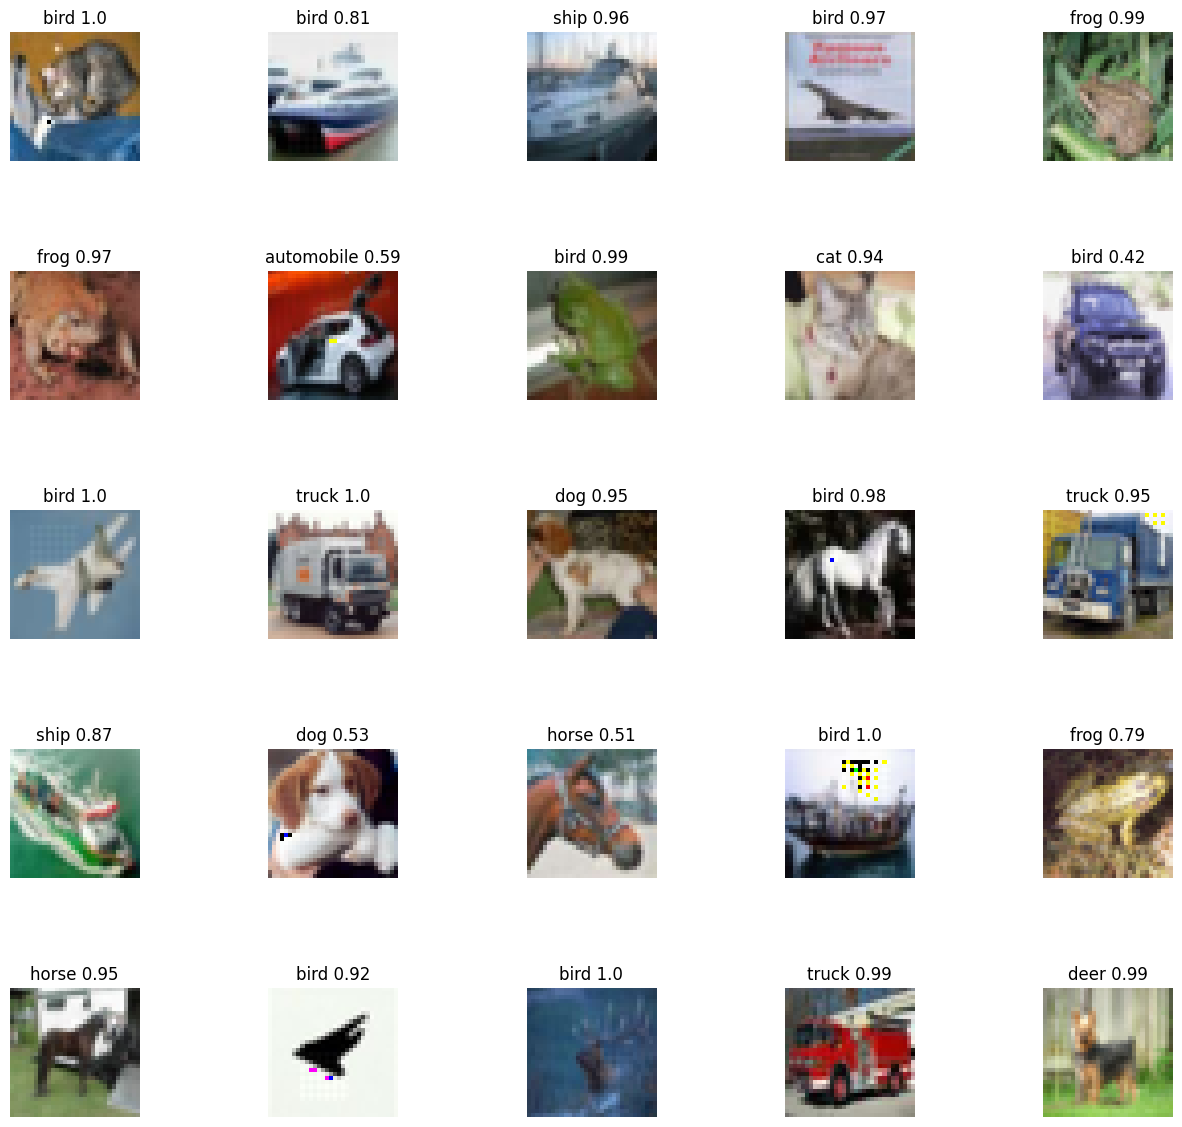

In [51]:
# Making the Predictions
# test_images = X_test_attacked

pred = model.predict(attacked_images)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)

#print predicted of each class
print(np.unique(pred_classes, return_counts=True))


fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(attacked_images[i])
    axes[i].set_title(class_names[pred_classes[i]] + " " + np.max(pred[i]).round(2).astype(str))
    #Print confidence
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [11]:
label = 4
#Take all the images of class 2
class_2_indexes = np.where(test_labels == label)[0]

class_2 = test_images[class_2_indexes]

#print name of class
print(class_names[label])

#show class_2[0]
plt.imshow(class_2[0])
#mean of each pixel in the images in int
mean = np.mean(class_2, axis=0).astype(int)

#heatmap of the mean
plt.imshow(mean)



deer


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tqdm import tqdm  # Importing tqdm for the progress bar

# Feature extraction of the model
feature_extractor = models.Model(inputs=model.inputs, outputs=model.layers[3].output)

def extract_features_batch(data, batch_size=32):
    features = []
    # Add tqdm to show progress
    for i in tqdm(range(0, len(data), batch_size), desc="Extracting Features", unit="batch"):
        batch = data[i:i+batch_size]
        batch_features = feature_extractor(batch)
        features.append(batch_features)
    return np.concatenate(features, axis=0)

#take the first 100 images
train_images_sample = train_images[:1000]
test_images_sample = test_images[:1000]
attacked_images_sample = attacked_images[:1000]

# Extract features of the train_images
train_features = extract_features_batch(train_images_sample)
test_features = extract_features_batch(test_images_sample)
attacked_features = extract_features_batch(attacked_images_sample)

# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
attacked_features_flat = attacked_features.reshape(attacked_features.shape[0], -1)

dbscan = DBSCAN(eps=0.5, min_samples=10)
train_clusters = dbscan.fit_predict(train_features_flat)

print("Cluster distribution:", np.unique(train_clusters, return_counts=True))



Extracting Features:   0%|          | 0/32 [00:00<?, ?batch/s]c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(
Extracting Features: 100%|██████████| 32/32 [00:00<00:00, 138.49batch/s]


Cluster distribution: (array([-1], dtype=int64), array([1000], dtype=int64))


In [30]:
# cluster the train_images with target class of 2
train_images_2 = train_images[np.where(train_labels == 2)[0]]

train_images_2_flat = train_images_2.reshape(train_images_2.shape[0], -1)

kmeans = KMeans(n_clusters=2, random_state=42).fit(train_images_2_flat)

test_images_flat = class_2.reshape(class_2.shape[0], -1)

attacked_images_flat = np.array(attacked_images)

attacked_images_flat = attacked_images_flat.reshape(attacked_images_flat.shape[0], -1)

# Predict the cluster of the test_images
test_clusters = kmeans.predict(test_images_flat)
attacked_clusters = kmeans.predict(attacked_images_flat)

# Print the cluster distribution
print("Test image cluster distribution:", np.unique(test_clusters, return_counts=True))
print("Attacked image cluster distribution:", np.unique(attacked_clusters, return_counts=True))



c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Test image cluster distribution: (array([0, 1]), array([278, 722], dtype=int64))
Attacked image cluster distribution: (array([0, 1]), array([4589, 5411], dtype=int64))


In [218]:
#Load all three models
model_original = models.load_model('model_original_30.h5')


model_colab = models.load_model("colab_model_3.h5")

loss, acc = model_original.evaluate(test_images, test_labels)
print(f"Original model accuracy: {acc:.4f}")

loss, acc = model_colab.evaluate(test_images, test_labels)
print(f"Colab model accuracy: {acc:.4f}")

test_labels_class = np.argmax(test_labels, axis=1)

def get_metrics(model):
    prediction = np.argmax(model.predict(test_images), axis=1)
    precision = precision_score(test_labels_class, prediction, average='macro')
    recall = recall_score(test_labels_class, prediction, average='macro')
    f1 = f1_score(test_labels_class, prediction, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

print("Original model")
get_metrics(model_original)

print("Colab model")
get_metrics(model_colab)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8516 - loss: 0.4392
Original model accuracy: 0.8524
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8489 - loss: 0.4746
Colab model accuracy: 0.8455
Original model
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Precision: 0.8543
Recall: 0.8524
F1-score: 0.8514
Colab model
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Precision: 0.8475
Recall: 0.8455
F1-score: 0.8424
